             CPIAUCSL     GDPC1    UNRATE
1948-03-31  23.616667  2239.682  3.733333
1948-06-30  23.993333  2276.690  3.666667
1948-09-30  24.396667  2289.770  3.766667
1948-12-31  24.173333  2292.364  3.833333
1949-03-31  23.943333  2260.807  4.666667


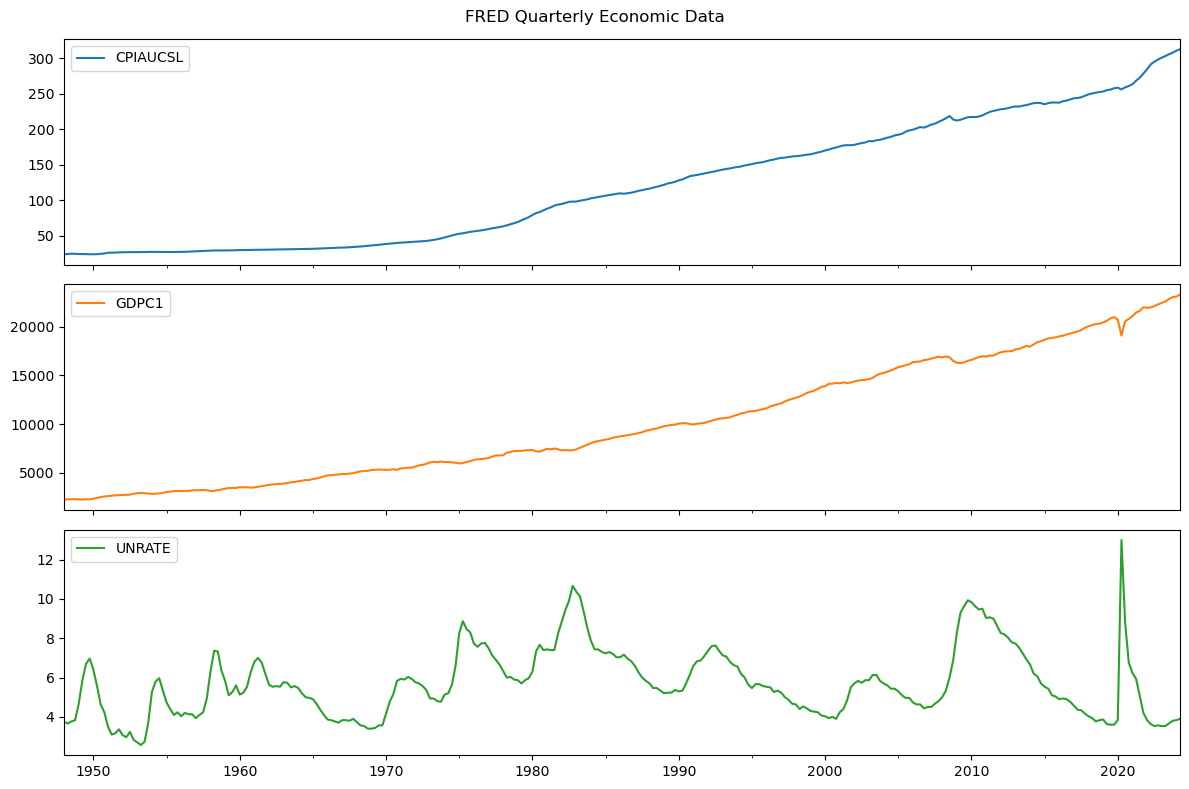

In [1]:
!pip install fredapi pandas matplotlib


import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt


fred = Fred(api_key='ebae0f5e94203bcf189646f2b8301870 ') 


start_date = '1948-01-01'
end_date = '2024-04-01'


cpi = fred.get_series('CPIAUCSL', observation_start=start_date, observation_end=end_date)
gdp = fred.get_series('GDPC1', observation_start=start_date, observation_end=end_date)
unrate = fred.get_series('UNRATE', observation_start=start_date, observation_end=end_date)


cpi = cpi.to_frame(name='CPIAUCSL')
gdp = gdp.to_frame(name='GDPC1')
unrate = unrate.to_frame(name='UNRATE')

cpi.index = pd.to_datetime(cpi.index)
gdp.index = pd.to_datetime(gdp.index)
unrate.index = pd.to_datetime(unrate.index)


cpi_q = cpi.resample('Q').mean()
unrate_q = unrate.resample('Q').mean()
gdp_q = gdp.resample('Q').ffill()  


start = max(cpi_q.index.min(), gdp_q.index.min(), unrate_q.index.min())
end = min(cpi_q.index.max(), gdp_q.index.max(), unrate_q.index.max())

cpi_q = cpi_q[(cpi_q.index >= start) & (cpi_q.index <= end)]
gdp_q = gdp_q[(gdp_q.index >= start) & (gdp_q.index <= end)]
unrate_q = unrate_q[(unrate_q.index >= start) & (unrate_q.index <= end)]


df = pd.concat([cpi_q, gdp_q, unrate_q], axis=1)


df = df.dropna()


print(df.head())


df.plot(subplots=True, figsize=(12, 8), title='FRED Quarterly Economic Data')
plt.tight_layout()
plt.show()


df.to_csv('fred_quarterly_data_cleaned.csv')


In [12]:
from statsmodels.tsa.stattools import adfuller
import numpy as np


def run_adf_test(series, name):
    result = adfuller(series, maxlag=1, autolag=None)  # 固定lag=1
    print(f"\nVariable: {name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Reject H0?" , "Yes" if result[1] < 0.05 else "No")
    print(f"Critical Values: {result[4]}")


run_adf_test(df['CPIAUCSL'], 'CPIAUCSL')
run_adf_test(df['GDPC1'], 'GDPC1')
run_adf_test(df['UNRATE'], 'UNRATE')


Variable: CPIAUCSL
ADF Statistic: 4.3692
p-value: 1.0000
Reject H0? No
Critical Values: {'1%': -3.452045317832011, '5%': -2.871094805558846, '10%': -2.571860921485457}

Variable: GDPC1
ADF Statistic: 3.7209
p-value: 1.0000
Reject H0? No
Critical Values: {'1%': -3.452045317832011, '5%': -2.871094805558846, '10%': -2.571860921485457}

Variable: UNRATE
ADF Statistic: -3.8189
p-value: 0.0027
Reject H0? Yes
Critical Values: {'1%': -3.452045317832011, '5%': -2.871094805558846, '10%': -2.571860921485457}


In [11]:
import numpy as np
from statsmodels.tsa.stattools import adfuller


df['dlog_CPI'] = np.log(df['CPIAUCSL']).diff()
df['dlog_GDP'] = np.log(df['GDPC1']).diff()


df_transformed = df[['dlog_CPI', 'dlog_GDP']].dropna()


def run_adf(series, name):
    result = adfuller(series, maxlag=1, autolag=None)
    print(f"\n{name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Reject H0?" , "Yes" if result[1] < 0.05 else "No")
    print(f"Critical Values: {result[4]}")


run_adf(df_transformed['dlog_CPI'], 'Log First Difference of CPI')
run_adf(df_transformed['dlog_GDP'], 'Log First Difference of GDP')


Log First Difference of CPI
ADF Statistic: -5.7054
p-value: 0.0000
Reject H0? Yes
Critical Values: {'1%': -3.4521175397304784, '5%': -2.8711265007266666, '10%': -2.571877823851692}

Log First Difference of GDP
ADF Statistic: -10.3170
p-value: 0.0000
Reject H0? Yes
Critical Values: {'1%': -3.4521175397304784, '5%': -2.8711265007266666, '10%': -2.571877823851692}



CPIAUCSL autocorrelation:
First lag where ACF < 0.5: lag None


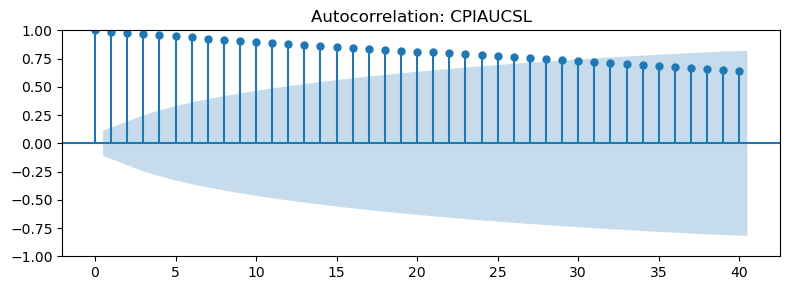


GDPC1 autocorrelation:
First lag where ACF < 0.5: lag None


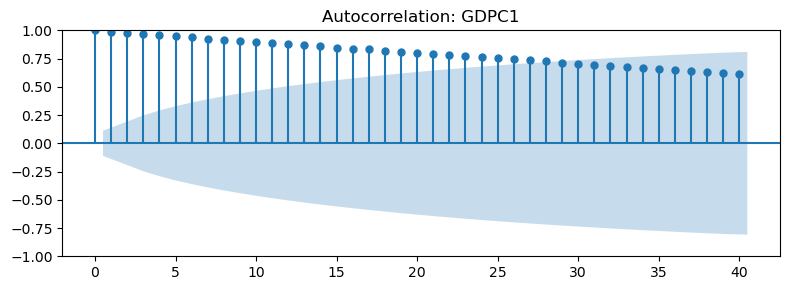


UNRATE autocorrelation:
First lag where ACF < 0.5: lag 6


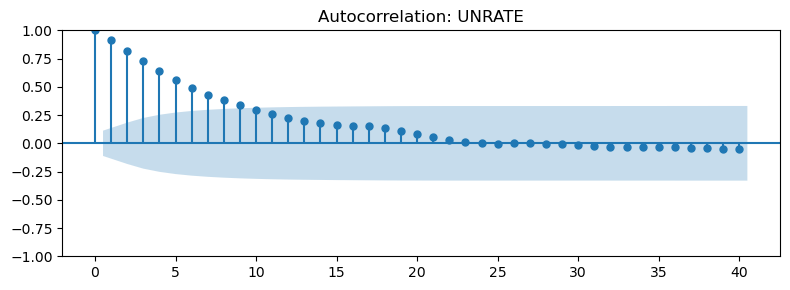


dlog_CPI autocorrelation:
First lag where ACF < 0.5: lag 4


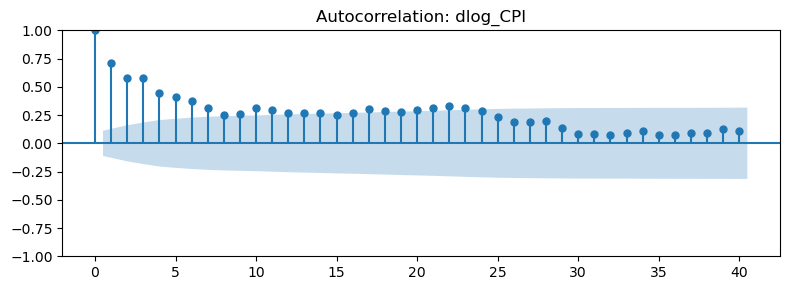


dlog_GDP autocorrelation:
First lag where ACF < 0.5: lag 1


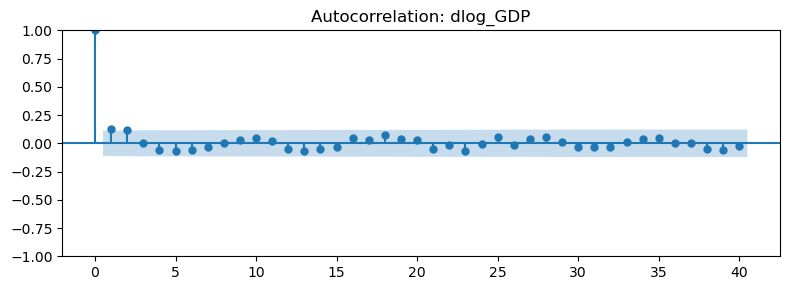

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


variables = {
    'CPIAUCSL': df['CPIAUCSL'],
    'GDPC1': df['GDPC1'],
    'UNRATE': df['UNRATE'],
    'dlog_CPI': df['dlog_CPI'].dropna(),
    'dlog_GDP': df['dlog_GDP'].dropna()
}


max_lag = 40


for name, series in variables.items():
    series = series.dropna()
    print(f"\n{name} autocorrelation:")

    acf_values = acf(series, nlags=max_lag)
    
    below_half_lag = next((i for i, val in enumerate(acf_values) if val < 0.5), None)
    print(f"First lag where ACF < 0.5: lag {below_half_lag}")
    
    
    fig, ax = plt.subplots(figsize=(8, 3))
    plot_acf(series, lags=max_lag, ax=ax, title=f'Autocorrelation: {name}')
    plt.tight_layout()
    plt.show()

In [6]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt


df_var = pd.DataFrame({
    'dlog_CPI': df['dlog_CPI'],
    'dlog_GDP': df['dlog_GDP'],
    'UNRATE_scaled': df['UNRATE'] / 100  
}).dropna()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Oct, 2025
Time:                     21:26:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -30.0154
Nobs:                     301.000    HQIC:                  -30.3035
Log likelihood:           3347.31    FPE:                5.70091e-14
AIC:                     -30.4957    Det(Omega_mle):     5.02175e-14
--------------------------------------------------------------------
Results for equation dlog_CPI
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.001430         0.001374           -1.041           0.298
L1.dlog_CPI              0.585097         0.059515            9.831           0.000
L1.dlog_GDP              0.085766         0.0

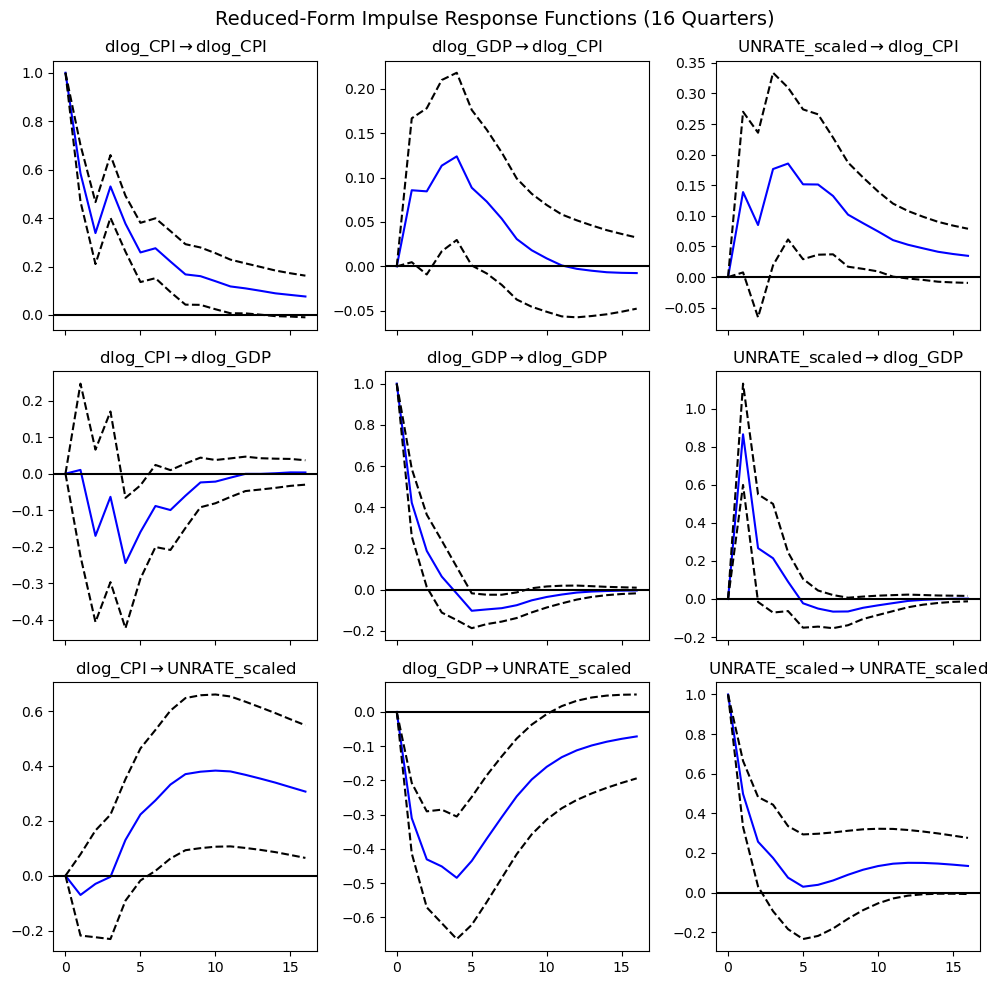

In [15]:
model = VAR(df_var)
results = model.fit(4)


print(results.summary())


irf = results.irf(16)  


fig = irf.plot(orth=False)
plt.suptitle("Reduced-Form Impulse Response Functions (16 Quarters)", fontsize=14)
plt.tight_layout()
plt.show()